# Project 1: Analyzing motorcycle parts sale using SQL and Python

In this project, I analyzed data from a company that sells motorcycle parts. I found the dataset from [this link](https://www.getsuper.ai/post/8-sql-project-ideas-for-your-resume-beginner-to-advanced) and developed my own business questions. To address these questions, I created a database using SQLite. I then wrote queries to extract insights in response to the business questions. To better illustrate the findings, I connected the database to Python and generated visualizations.

1. **Monthly Revenue Trends**
    1. What is the total revenue each month across all product lines?
    2. Which months have the highest and lowest revenue, and which warehouse contributes the most?
    
2. **Product and Warehouse Performance**
    1. Which product types bring in the most revenue each month?
    2. Which product lines show the highest revenue growth month-over-month?
    3. Do certain products perform better in specific warehouses?
    
3. **Client Types and Revenue**
    1. Which client type generates the most revenue overall?
    2. Which client type generates the most revenue in each warehouse?

 


This notebook is structured in the same format for all business questions: first, the query, followed by the plot, and then the conclusions.

# Connecting to the database:

In [1]:
import sqlite3

try:
    print('Creating database connection')
    conn = sqlite3.connect('sales_data.sqlite')
    print('Connection successful')
except sqlite3.Error as e:
    print(f"Error occurred: {e}")


Creating database connection
Connection successful


# 1. Monthly Revenue Trends

## 1. What is the total revenue each month across all product lines?

Note on Date Formatting

It is worth mentioning that in the SQLite database, the date is stored in the **Day-Month-Year** format.

To properly handle this, I used the `strftime` function in SQL to convert the date into the **Year-Month** format.

In [2]:
import pandas as pd


def queries_revenue_total(conn):
    query = """
    SELECT
    strftime('%Y-%m', substr(formatted_date, 7, 4) || '-' || substr(formatted_date, 4, 2) || '-' || substr(formatted_date, 1, 2)) AS month,
    SUM(total) AS total_revenue
    FROM sales
    GROUP BY month
    ORDER BY month;
    """
    return pd.read_sql_query(query, conn)

revenue_total = queries_revenue_total(conn)

#Now I will filter the data and remove months with NaN entries
renevue_cleaned = revenue_total[revenue_total['month'].notna()]

In the following code, I will plot the results. Note that I have computed the month-by-month difference in revenues and use an arrow on the plot to highlight this difference:

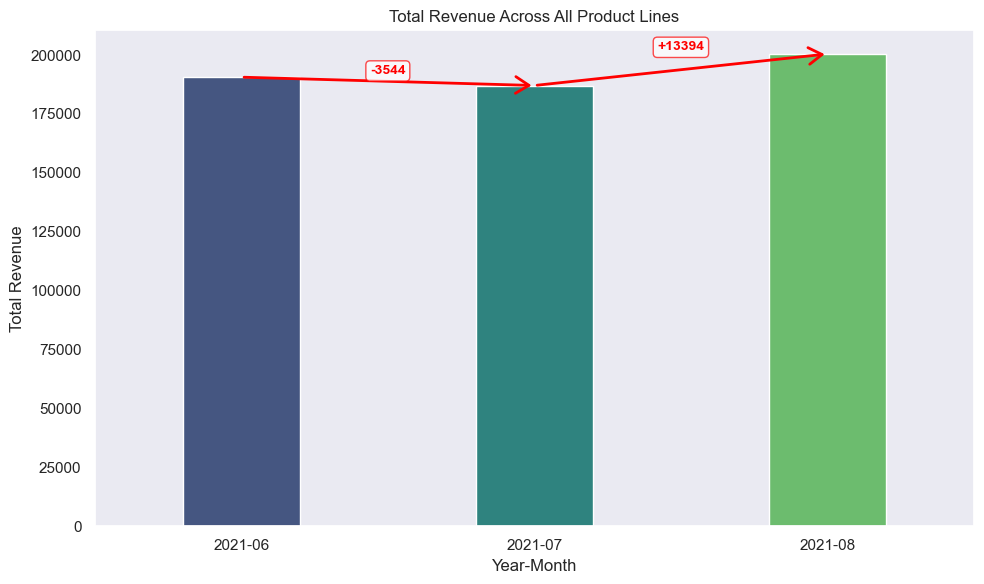

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")

def plot_bar_graph_1_1(dataframe):
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="month", y="total_revenue", data=dataframe, 
                    hue='month', palette="viridis", width=0.4)
    
    # Add title and labels
    ax.set_title("Total Revenue Across All Product Lines")
    ax.set_xlabel("Year-Month")
    ax.set_ylabel("Total Revenue")
    
    # Iterate over the bars to add enhanced arrows and annotations
    for i in range(len(ax.patches) - 1):  # Loop through all bars except the last
        bar1 = ax.patches[i]  # Current bar
        bar2 = ax.patches[i + 1]  # Next bar
        
        # Get the x, y positions and heights of the bars
        x1 = bar1.get_x() + bar1.get_width() / 2  # Center of the first bar
        y1 = bar1.get_height()  # Height of the first bar
        x2 = bar2.get_x() + bar2.get_width() / 2  # Center of the second bar
        y2 = bar2.get_height()  # Height of the second bar
        
        # Calculate the difference in revenue
        difference = y2 - y1
        
        # Add an arrow showing the difference
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                    arrowprops=dict(arrowstyle='->,head_width=0.5,head_length=0.8', 
                                    color='red', lw=2, alpha=1, linestyle='-'))
        
        # Add a text label for the difference
        ax.annotate(f'{difference:+.0f}',  # Include '+' for positive, format without decimals
                    xy=((x1 + x2) / 2, max(y1, y2) + abs(difference) * 0.02),  # Position slightly above the taller bar
                    ha='center', va='bottom', fontsize=10, color='red', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', edgecolor='red', facecolor='white', alpha=0.7))  # Label background
    
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
plot_bar_graph_1_1(renevue_cleaned)

Looking at the figure, we can see a slight variation in revenue throughout the analyzed period. However, August stands out as the month with the highest revenue, while July experiences the lowest. Now, let's dive deeper into the revenue trends for these two months. 

## 2. Which months have the highest and lowest revenue, and which warehouse contributes the most?

In [4]:
def queries_revenue_month_l(conn):
    query = """
    WITH total_revenue_per_month AS (
        SELECT
            strftime('%Y-%m', substr(formatted_date, 7, 4) || '-' || substr(formatted_date, 4, 2) || '-' || substr(formatted_date, 1, 2)) AS month,
            SUM(total) AS total_revenue
        FROM sales
        GROUP BY month

    ),
    lowest_revenue_month AS (
        SELECT
            month,
            total_revenue
        FROM total_revenue_per_month
        ORDER BY total_revenue ASC
        LIMIT 1 OFFSET 1
    ),
    highest_contribution AS (
        SELECT
            s.warehouse,
            SUM(s.total) AS warehouse_revenue,
            hr.month
        FROM sales s
        JOIN lowest_revenue_month hr
            ON strftime('%Y-%m', substr(s.formatted_date, 7, 4) || '-' || substr(s.formatted_date, 4, 2) || '-' || substr(s.formatted_date, 1, 2)) = hr.month
        GROUP BY s.warehouse
        ORDER BY warehouse_revenue ASC
    )

    SELECT *
    FROM highest_contribution
    """
    return pd.read_sql_query(query, conn)


def queries_revenue_month_h(conn):
    query = """
    WITH total_revenue_per_month AS (
        SELECT
            strftime('%Y-%m', substr(formatted_date, 7, 4) || '-' || substr(formatted_date, 4, 2) || '-' || substr(formatted_date, 1, 2)) AS month,
            SUM(total) AS total_revenue
        FROM sales
        GROUP BY month

    ),
    highest_revenue_month AS (
        SELECT
            month,
            total_revenue
        FROM total_revenue_per_month
        ORDER BY total_revenue DESC
        LIMIT 1
    ),
    highest_contribution AS (
        SELECT
            s.warehouse,
            SUM(s.total) AS warehouse_revenue,
            hr.month
        FROM sales s
        JOIN highest_revenue_month hr
            ON strftime('%Y-%m', substr(s.formatted_date, 7, 4) || '-' || substr(s.formatted_date, 4, 2) || '-' || substr(s.formatted_date, 1, 2)) = hr.month
        GROUP BY s.warehouse
        ORDER BY warehouse_revenue ASC
    )

    SELECT *
    FROM highest_contribution
    """
    return pd.read_sql_query(query, conn)


revenue_high_month = queries_revenue_month_h(conn)
revenue_low_month = queries_revenue_month_l(conn)

Plotting the results

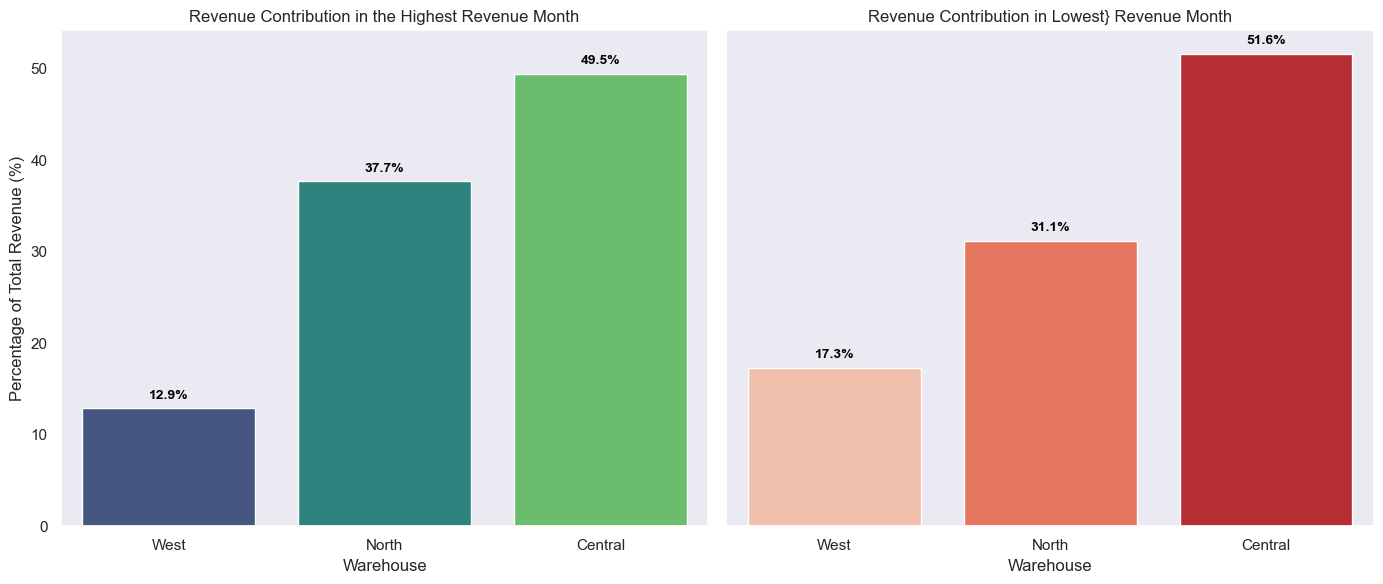

In [5]:
def plot_bar_graph_1_2(dataframe1, dataframe2):
    # Normalize data to percentages
    dataframe1['percentage'] = (dataframe1['warehouse_revenue'] / dataframe1['warehouse_revenue'].sum()) * 100
    dataframe2['percentage'] = (dataframe2['warehouse_revenue'] / dataframe2['warehouse_revenue'].sum()) * 100

    # Create the combined figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Plot highest revenue month
    sns.barplot(
        x="warehouse", y="percentage", data=dataframe1, 
        hue="warehouse",palette="viridis", ax=ax[0]
    )
    ax[0].set_title("Revenue Contribution in the Highest Revenue Month")
    ax[0].set_xlabel("Warehouse")
    ax[0].set_ylabel("Percentage of Total Revenue (%)")
    
    # Add annotations for the first plot
    for p in ax[0].patches:
        height = p.get_height()  
        ax[0].annotate(
            f'{height:.1f}%', 
            (p.get_x() + p.get_width() / 2., height), 
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='black',
            xytext=(0, 5), textcoords='offset points'  # Small offset above the bar
        )

    # Plot lowest revenue month
    sns.barplot(
        x="warehouse", y="percentage", data=dataframe2, 
        hue='warehouse',palette="Reds", ax=ax[1]
    )
    ax[1].set_title("Revenue Contribution in Lowest} Revenue Month")
    ax[1].set_xlabel("Warehouse")
    ax[1].set_ylabel("")  # Avoid repeating the y-axis label 
    
    # Add annotations for the second plot
    for p in ax[1].patches:
        height = p.get_height()  # Percentage value (bar height)
        ax[1].annotate(
            f'{height:.1f}%', 
            (p.get_x() + p.get_width() / 2., height), 
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='black',
            xytext=(0, 5), textcoords='offset points'  # Small offset above the bar
        )

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

plot_bar_graph_1_2(revenue_high_month,revenue_low_month)


We can observe that the Central warehouse contributes the most to the revenue in both scenarios. In addition, the West warehouse has the lowest percentage of total revenue.

# 2. Product and Warehouse Performance

## 1 Which product types bring in the most revenue each month?

In [6]:
def queries_product_revenue(conn):
    query = """
    WITH total_revenue_per_month AS (
    SELECT
    strftime('%Y-%m', substr(s.formatted_date, 7, 4) || '-' || substr(s.formatted_date, 4, 2) || '-' || substr(s.formatted_date, 1, 2)) AS month,
    SUM(s.total) AS total_revenue
    FROM sales s
    GROUP BY month
    )

    SELECT tr.month, s.product_line,
    tr.total_revenue, SUM(s.total) AS product_line_revenue
    FROM sales s
    JOIN total_revenue_per_month tr
    ON strftime('%Y-%m', substr(s.formatted_date, 7, 4) || '-' || substr(s.formatted_date, 4, 2) || '-' || substr(s.formatted_date, 1, 2)) = tr.month
    GROUP BY tr.month, s.product_line, tr.total_revenue
    ORDER BY tr.month, s.product_line;
    """
    return pd.read_sql_query(query, conn)

product_revenue_month = queries_product_revenue(conn)


Plotting the results. I also included the percentage of each product line (it was challenging to align them on the y-axis), but I really enjoyed the result.


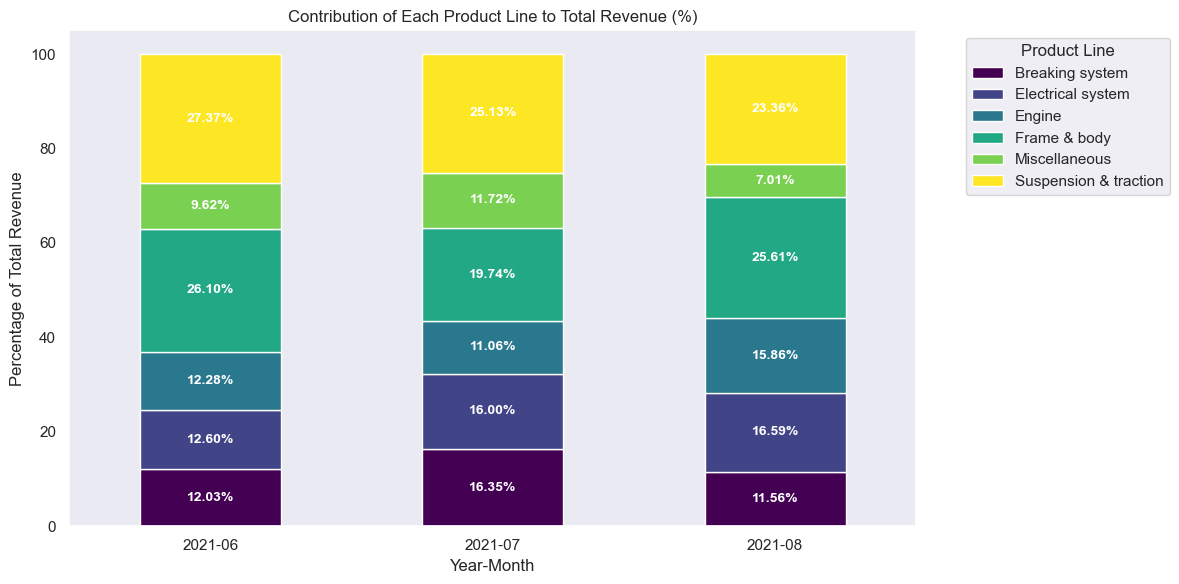

In [7]:
def plot_bar_graph_2_1(dataframe):
    # Pivot the dataframe to get the total revenue per product line
    pivot_df = dataframe.pivot_table(index='month', columns='product_line', values='product_line_revenue', aggfunc='sum')
    
    # Calculate the total revenue per month
    total_revenue = pivot_df.sum(axis=1)
    
    # Normalize the pivot_df to get the percentage contribution
    percentage_df = pivot_df.div(total_revenue, axis=0) * 100
    
    # Plot the stacked bar chart
    ax = percentage_df.plot(kind='bar', stacked=True, figsize=(12, 6), cmap='viridis')
    
    # Annotate the bars with the percentage values
    for p in ax.patches:
        # Get the height and the bottom position of the bar segment
        height = p.get_height()
        x = p.get_x() + p.get_width() / 2.  # X position: center of the bar
        y = p.get_y() + height / 2  # Y position!!!
        
        
        # Annotate the bars with the percentage value (rounded to 2 decimal places)
        ax.annotate(f'{height:.2f}%', 
                    (x, y),  # Position at the center of each bar
                    ha='center', va='center', fontsize=10, color='white', fontweight='bold')

    ax.set_title('Contribution of Each Product Line to Total Revenue (%)')
    ax.set_xlabel('Year-Month')
    ax.set_ylabel('Percentage of Total Revenue')

    # Rotate x-axis labels horizontally
    plt.xticks(rotation=0)

    ax.legend(title='Product Line', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_bar_graph_2_1(product_revenue_month)


The product lines that contribute the highest percentage of revenue are Suspension and Traction, followed by Frame and Body. It is worth mentioning that Miscellaneous has the lowest contribution.

## 2. Which product lines show the highest revenue growth month-over-month?


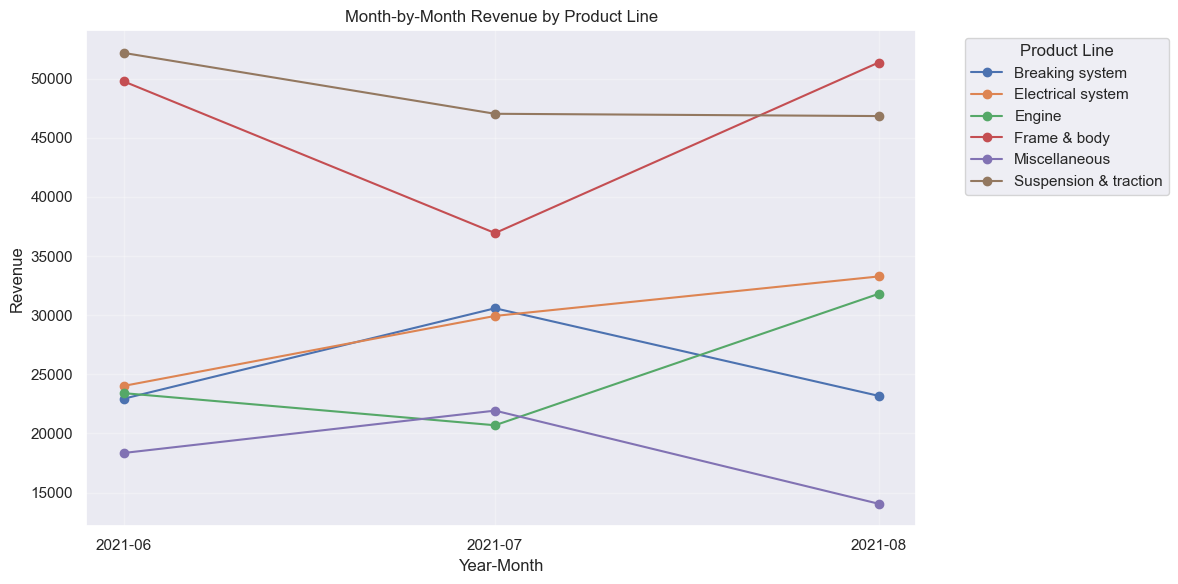

In [8]:
def plot_line_graph_2_2(dataframe):
    dataframe['month'] = pd.to_datetime(dataframe['month'])
    dataframe = dataframe.sort_values(by='month')
    
    # Pivot to structure data for plotting
    pivot_df = dataframe.pivot_table(index='month', columns='product_line', values='product_line_revenue', aggfunc='sum')

    # Plotting
    plt.figure(figsize=(12, 6))
    for product_line in pivot_df.columns:
        plt.plot(
            pivot_df.index, 
            pivot_df[product_line], 
            marker='o', label=product_line  # Line with markers
        )
    
    # Formatting
    plt.title("Month-by-Month Revenue by Product Line")
    plt.xlabel("Year-Month")
    plt.ylabel("Revenue")
    plt.xticks(pivot_df.index, pivot_df.index.strftime('%Y-%m'), rotation=0)  # Format months nicely
    plt.legend(title="Product Line", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_line_graph_2_2(product_revenue_month)


Electrical systems shows the highest revenue growth in the analyzed period. On the other hand, suspension & traction shows a decline in the revenue contribution. 

## 3. Do certain products perform better in specific warehouses?


In [9]:
def queries_product_warehouse(conn): 
    query = """
    WITH total_revenue_per_month AS (
    SELECT
    strftime('%Y-%m', substr(s.formatted_date, 7, 4) || '-' || substr(s.formatted_date, 4, 2) || '-' || substr(s.formatted_date, 1, 2)) AS month,
    SUM(s.total) AS total_revenue
    FROM sales s
    GROUP BY month
    )
    SELECT tr.month, s.product_line,
    s.warehouse, printf("%.2f", SUM(s.total)) AS product_line_revenue_per_warehouse
    FROM sales s
    JOIN total_revenue_per_month tr
    ON strftime('%Y-%m', substr(s.formatted_date, 7, 4) || '-' || substr(s.formatted_date, 4, 2) || '-' || substr(s.formatted_date, 1, 2)) = tr.month
    GROUP BY tr.month, s.product_line, s.warehouse
    ORDER BY tr.month, s.product_line, s.warehouse; 
    """
    return pd.read_sql_query(query, conn)


product_warehouse=queries_product_warehouse(conn)

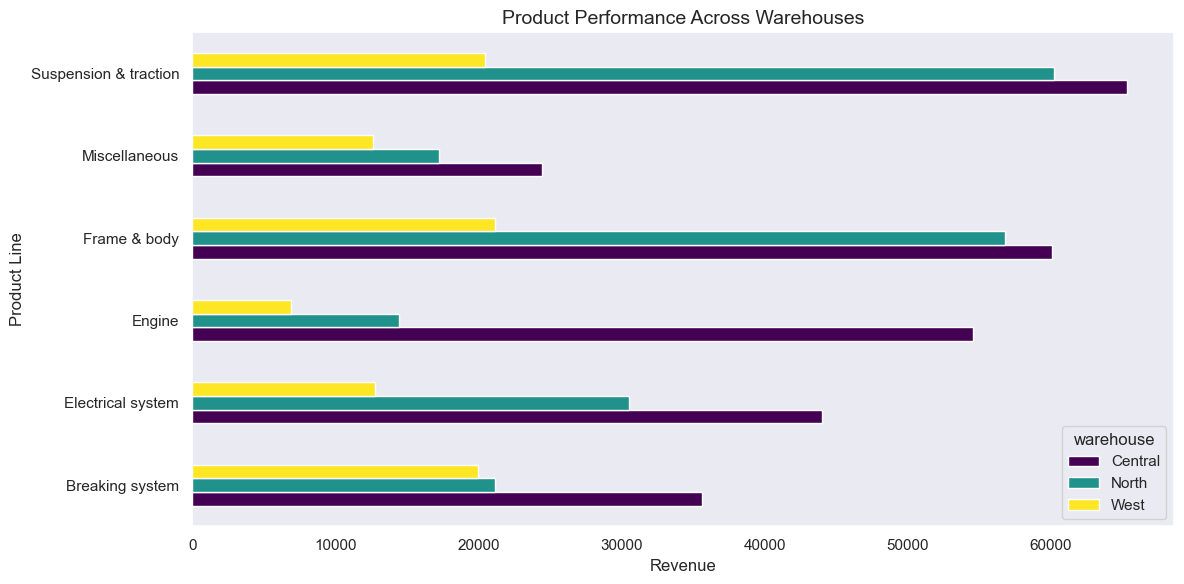

In [10]:
def plot_bar_graph_2_3(dataframe):
    dataframe['product_line_revenue_per_warehouse'] = pd.to_numeric(dataframe['product_line_revenue_per_warehouse'], errors='coerce')
    
    # Pivot the data to sum up revenue for each product line across different warehouses
    pivot_df = dataframe.pivot_table(index='product_line', columns='warehouse', 
                                     values='product_line_revenue_per_warehouse', aggfunc='sum', fill_value=0)
    
    # Plot the data using horizontal bars
    pivot_df.plot(kind='barh', stacked=False, colormap='viridis', figsize=(12, 6))

    # Formatting the plot
    plt.title("Product Performance Across Warehouses", fontsize=14)
    plt.xlabel("Revenue")
    plt.ylabel("Product Line")
    plt.tight_layout()
    plt.show()

plot_bar_graph_2_3(product_warehouse)


All product lines generate higher revenue in the Central warehouse, while the West warehouse consistently has the lowest revenue. The only exception is the braking system, which is sold in similar amounts in both the North and West warehouses.


# 3. Client Types and Revenue

## 1. Which client type generates the most revenue overall?

In [11]:
def queries_client_revenue(conn): 
    query = """
    WITH total_revenue_per_month AS (
    SELECT
        strftime('%Y-%m', substr(s.formatted_date, 7, 4) || '-' || substr(s.formatted_date, 4, 2) || '-' || substr(s.formatted_date, 1, 2)) AS month,
        SUM(s.total) AS total_revenue
    FROM sales s
    GROUP BY month)

    SELECT tr.month,s.client_type,
        SUM(s.total) AS revenue_per_client,
        tr.total_revenue 
    FROM sales s
    JOIN total_revenue_per_month tr
    ON strftime('%Y-%m', substr(s.formatted_date, 7, 4) || '-' || substr(s.formatted_date, 4, 2) || '-' || substr(s.formatted_date, 1, 2)) = tr.month
    GROUP BY tr.month, s.client_type
    ORDER BY tr.month, s.client_type;
    """
    return pd.read_sql_query(query, conn)

client_revenue_month = queries_client_revenue(conn)



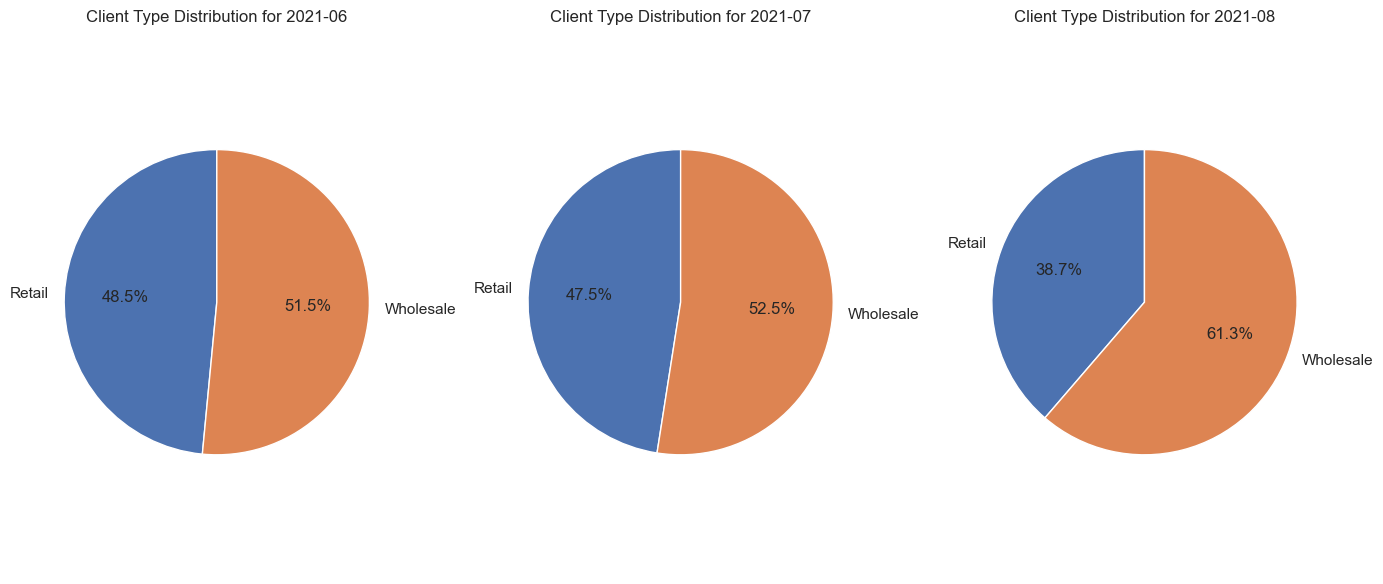

In [12]:
def plot_pie_graph_3_1(dataframe):
    dataframe['percentage'] = dataframe['revenue_per_client'] / dataframe['total_revenue'] * 100
    fig, axes = plt.subplots(1, 3, figsize=(14, 6))
    months = ['2021-06', '2021-07', '2021-08']

    for i, month in enumerate(months):
        # Filter data for the current month
        month_data = dataframe[dataframe['month'] == month]
        axes[i].pie(month_data['percentage'], labels=month_data['client_type'], autopct='%1.1f%%', startangle=90)
        axes[i].set_title(f'Client Type Distribution for {month}')
        axes[i].axis('equal')

    plt.tight_layout()
    plt.show()

plot_pie_graph_3_1(client_revenue_month)


Wholesale generates the highest revenue during the analyzed period.

## 2. Which client type generates the most revenue in each warehouse?

In [13]:
def queries_client_warehouse(conn):
    query = """
    WITH total_revenue_per_month AS (
    SELECT
        strftime('%Y-%m', substr(s.formatted_date, 7, 4) || '-' || substr(s.formatted_date, 4, 2) || '-' || substr(s.formatted_date, 1, 2)) AS month,
        SUM(s.total) AS total_revenue
    FROM sales s
    GROUP BY month)   
    SELECT tr.month,s.client_type,s.warehouse,
        SUM(s.total) AS revenue_per_client
    FROM sales s
    JOIN total_revenue_per_month tr
        ON strftime('%Y-%m', substr(s.formatted_date, 7, 4) || '-' || substr(s.formatted_date, 4, 2) || '-' || substr(s.formatted_date, 1, 2)) = tr.month
    GROUP BY tr.month, s.warehouse, s.client_type
    ORDER BY tr.month,  s.warehouse, s.client_type; 
    """
    return pd.read_sql_query(query, conn)

client_revenue_warehouse=queries_client_warehouse(conn)


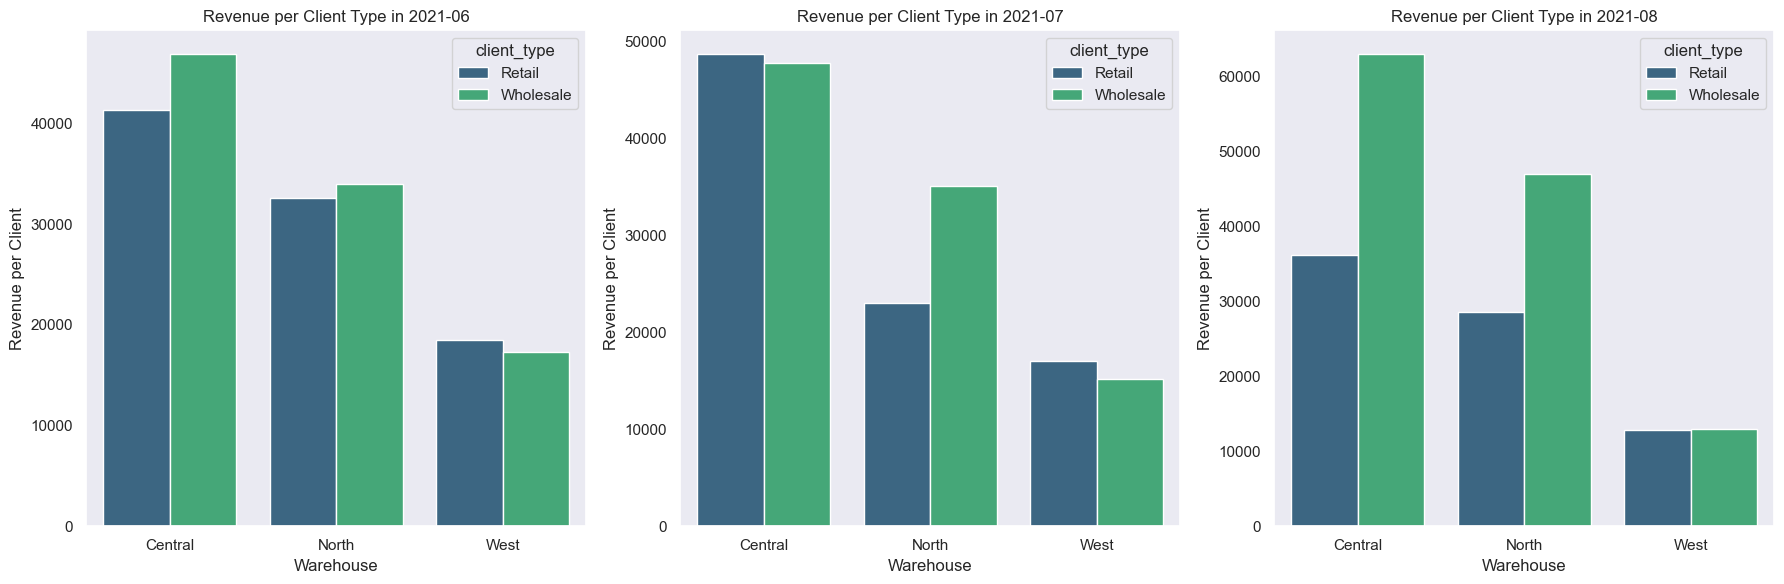

In [14]:
def plot_bar_graph_3_2(dataframe):
    months = dataframe['month'].unique()
    
    # Set up the plot with subplots (1 per month)
    fig, axes = plt.subplots(1, len(months), figsize=(18, 6))

    # Loop through each month and plot the bar chart
    for i, month in enumerate(months):
        month_data = dataframe[dataframe['month'] == month]
        
        # Create a bar plot for client type revenue in each warehouse
        sns.barplot(x="warehouse", y="revenue_per_client", hue="client_type", data=month_data, ax=axes[i], palette="viridis")
        
        # Set title and labels for the current subplot
        axes[i].set_title(f'Revenue per Client Type in {month}', fontsize=12)
        axes[i].set_xlabel('Warehouse', fontsize=12)
        axes[i].set_ylabel('Revenue per Client', fontsize=12)
        axes[i].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.show()


plot_bar_graph_3_2(client_revenue_warehouse)


Overall, Wholesale generates more revenue across all warehouses. The only exception is in August 2021 at the West warehouse, where Retail and Wholesale achieve similar revenue.


In [15]:
conn.close()